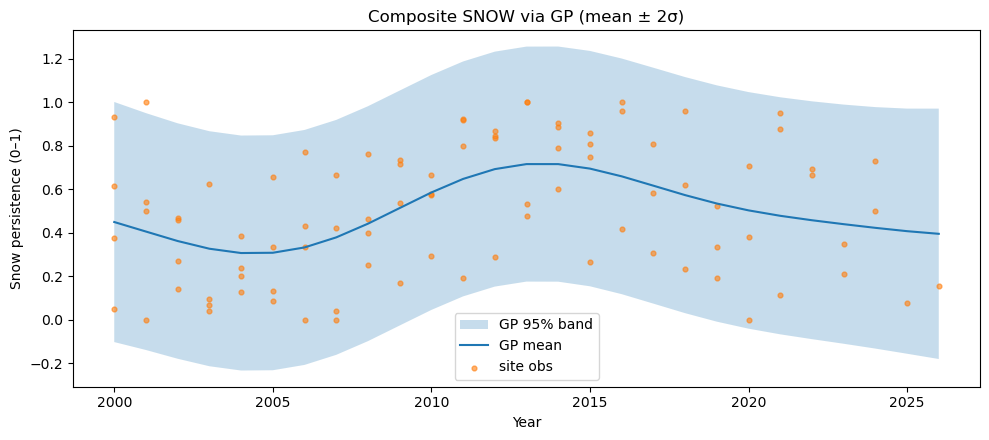

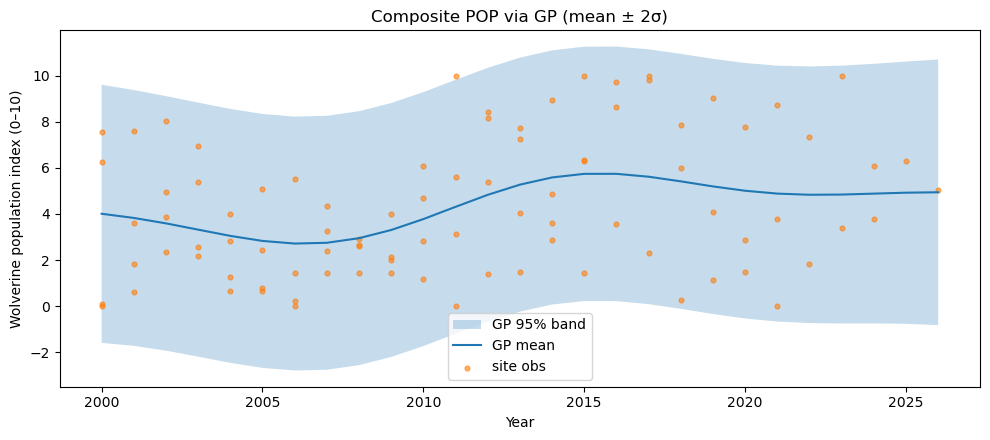

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


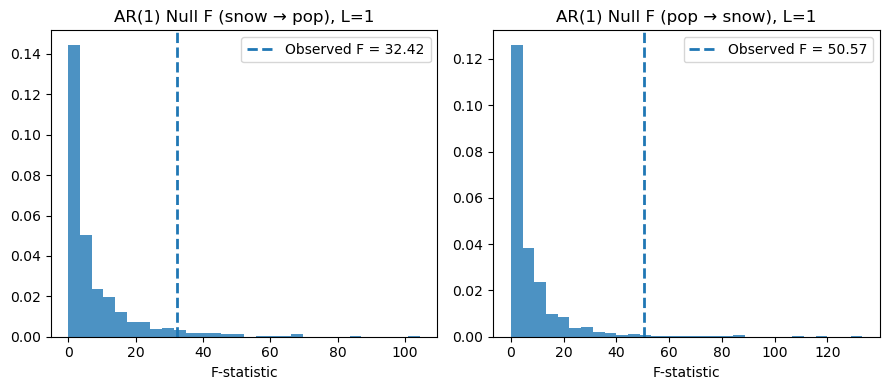

{'lag_L': 1, 'F_snow_to_pop': 32.42103655820871, 'theory_p_snow_to_pop': 8.487574881103572e-06, 'empirical_p_snow_to_pop_AR1': np.float64(0.04695304695304695), 'F_pop_to_snow': 50.56584688253376, 'theory_p_pop_to_snow': 3.0427278919947485e-07, 'empirical_p_pop_to_snow_AR1': np.float64(0.017982017982017984), 'phi_xsnow': 0.9568508267394396, 'sigma_xsnow': 0.2961149318798476, 'phi_ypop': 0.9681486872988878, 'sigma_ypop': 0.2551454502676169}
Significant Granger causality detected: snow → pop
Significant Granger causality detected: pop → snow


In [26]:
# %%
# Wolverine multi-site short series -> GP composite + Granger (statsmodels) + AR(1) random null
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import warnings

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel, DotProduct
from statsmodels.tsa.stattools import grangercausalitytests

warnings.filterwarnings("ignore", category=UserWarning)
rng = np.random.default_rng(42)

# ------------------------
# 0) Generate synthetic data (same as before)
# ------------------------
loc_ids = [f"loc{i+1}" for i in range(4)]
lengths = rng.integers(15, 31, size=4).tolist()
records = []
for loc, n in zip(loc_ids, lengths):
    phi = 0.7
    e = rng.normal(0, 0.3, size=n)
    s = np.zeros(n)
    s[0] = rng.normal(0, 1)
    for t in range(1, n):
        s[t] = phi * s[t-1] + e[t]
    snow = (pd.Series(s).rank(method="average").to_numpy() - 1) / (n - 1)

    pop = np.zeros(n)
    pop[0] = rng.normal(0, 1)
    for t in range(1, n):
        pop[t] = 0.55 * pop[t-1] + 0.45 * snow[t-1] + rng.normal(0, 0.2)
    pop = (pop - pop.min()) / (pop.max() - pop.min() + 1e-12) * 10

    years = np.arange(2000, 2000 + n)
    for t in range(n):
        records.append({"location": loc, "year": int(years[t]), "snow": float(snow[t]), "pop": float(pop[t])})

df = pd.DataFrame(records).sort_values(["location", "year"]).reset_index(drop=True)

# ------------------------
# 1) GP composites on union time grid
# ------------------------
t_min = int(df["year"].min()); t_max = int(df["year"].max())
t_grid = np.arange(t_min, t_max + 1).astype(float).reshape(-1, 1)

def fit_gp(time_col, y_col):
    X = df[[time_col]].astype(float).to_numpy()
    y = df[y_col].to_numpy()
    kernel = (
        C(1.0, (1e-2, 1e3)) * RBF(length_scale=5.0, length_scale_bounds=(1.0, 50.0))
        + 0.1 * DotProduct(sigma_0=1.0)
        + WhiteKernel(noise_level=0.05, noise_level_bounds=(1e-5, 1.0))
    )
    gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True, alpha=1e-6, random_state=0, n_restarts_optimizer=3)
    gpr.fit(X, y)
    mu, std = gpr.predict(t_grid, return_std=True)
    return mu, std

snow_mu, snow_std = fit_gp("year", "snow")
pop_mu,  pop_std  = fit_gp("year", "pop")

comp = pd.DataFrame({
    "year": t_grid.ravel().astype(int),
    "snow_mean": snow_mu, "snow_std": snow_std,
    "pop_mean":  pop_mu,  "pop_std":  pop_std
})

# ------------------------
# 2) Visualize GP means ± 2σ (no saving)
# ------------------------
x_year = comp["year"].to_numpy()
snow_mu = comp["snow_mean"].to_numpy(dtype=float)
snow_std = comp["snow_std"].to_numpy(dtype=float)
pop_mu  = comp["pop_mean"].to_numpy(dtype=float)
pop_std = comp["pop_std"].to_numpy(dtype=float)

plt.figure(figsize=(10,4.5))
plt.title("Composite SNOW via GP (mean ± 2σ)")
plt.fill_between(x_year, snow_mu-2*snow_std, snow_mu+2*snow_std, alpha=0.25, label="GP 95% band")
plt.plot(x_year, snow_mu, label="GP mean")
plt.scatter(df["year"], df["snow"], s=12, alpha=0.6, label="site obs")
plt.xlabel("Year"); plt.ylabel("Snow persistence (0–1)")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4.5))
plt.title("Composite POP via GP (mean ± 2σ)")
plt.fill_between(x_year, pop_mu-2*pop_std, pop_mu+2*pop_std, alpha=0.25, label="GP 95% band")
plt.plot(x_year, pop_mu, label="GP mean")
plt.scatter(df["year"], df["pop"], s=12, alpha=0.6, label="site obs")
plt.xlabel("Year"); plt.ylabel("Wolverine population index (0–10)")
plt.legend(); plt.tight_layout(); plt.show()

# ------------------------
# 3) Granger via statsmodels on z-scored GP means, lag L=1
# ------------------------
L = 1
y_pop  = stats.zscore(comp["pop_mean"].to_numpy(dtype=float))
x_snow = stats.zscore(comp["snow_mean"].to_numpy(dtype=float))

def granger_F(y, x, L=1):
    # statsmodels wants columns [y, x]
    res = grangercausalitytests(np.column_stack([y, x]), maxlag=L, verbose=False)
    F, p, _, _ = res[L][0]["ssr_ftest"]  # SSR-based F-test
    return float(F), float(p)

F_s2p, p_s2p = granger_F(y_pop, x_snow, L=L)  # snow -> pop
F_p2s, p_p2s = granger_F(x_snow, y_pop, L=L)  # pop -> snow

# ------------------------
# 4) AR(1) parametric randomization null (independent)
#    - For snow→pop: keep y_pop fixed; simulate x_snow surrogates ~ AR(1) with matched phi/sigma.
#    - For pop→snow: keep x_snow fixed; simulate y_pop surrogates ~ AR(1) with matched phi/sigma.
# ------------------------
def estimate_ar1_params(z):
    """Estimate AR(1): z_t = phi*z_{t-1} + e_t, z is zero-mean (use z-scored input)."""
    z = np.asarray(z, float)
    r1 = np.corrcoef(z[:-1], z[1:])[0,1]
    phi = float(np.clip(r1, -0.99, 0.99))
    var = np.var(z, ddof=1)
    sigma = float(np.sqrt(max(1e-12, var*(1 - phi**2))))
    return phi, sigma

def simulate_ar1(phi, sigma, n, rng, burn=200):
    """Stationary AR(1) simulator (zero-mean)."""
    z = np.zeros(n + burn)
    z[0] = rng.normal(0, sigma/np.sqrt(1 - phi**2 + 1e-12))
    eps = rng.normal(0, sigma, size=n + burn)
    for t in range(1, n + burn):
        z[t] = phi*z[t-1] + eps[t]
    z = z[burn:]
    # standardize for stability like the observed comps
    z = (z - z.mean()) / (z.std(ddof=1) + 1e-12)
    return z

phi_x, sig_x = estimate_ar1_params(x_snow)
phi_y, sig_y = estimate_ar1_params(y_pop)

Nnull = 1000
F_null_s2p = np.empty(Nnull)
F_null_p2s = np.empty(Nnull)

for i in range(Nnull):
    # snow → pop: randomize the driver (x), keep response (y) fixed
    x_sim = simulate_ar1(phi_x, sig_x, len(x_snow), rng)
    F_null_s2p[i], _ = granger_F(y_pop, x_sim, L=L)

    # pop → snow: randomize the driver (y), keep response (x) fixed
    y_sim = simulate_ar1(phi_y, sig_y, len(y_pop), rng)
    F_null_p2s[i], _ = granger_F(x_snow, y_sim, L=L)

p_emp_s2p = (1 + np.sum(F_null_s2p >= F_s2p)) / (1 + Nnull)
p_emp_p2s = (1 + np.sum(F_null_p2s >= F_p2s)) / (1 + Nnull)

# ------------------------
# 5) Plot null histograms with observed F (no saving)
# ------------------------
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.title(f"AR(1) Null F (snow → pop), L={L}")
plt.hist(F_null_s2p, bins=30, alpha=0.8, density=True)
plt.axvline(F_s2p, linestyle="--", linewidth=2, label=f"Observed F = {F_s2p:.2f}")
plt.xlabel("F-statistic"); plt.legend()

plt.subplot(1,2,2)
plt.title(f"AR(1) Null F (pop → snow), L={L}")
plt.hist(F_null_p2s, bins=30, alpha=0.8, density=True)
plt.axvline(F_p2s, linestyle="--", linewidth=2, label=f"Observed F = {F_p2s:.2f}")
plt.xlabel("F-statistic"); plt.legend()

plt.tight_layout(); plt.show()

# ------------------------
# 6) Print summary
# ------------------------
print({
    "lag_L": L,
    "F_snow_to_pop": F_s2p,
    "theory_p_snow_to_pop": p_s2p,
    "empirical_p_snow_to_pop_AR1": p_emp_s2p,
    "F_pop_to_snow": F_p2s,
    "theory_p_pop_to_snow": p_p2s,
    "empirical_p_pop_to_snow_AR1": p_emp_p2s,
    "phi_xsnow": phi_x, "sigma_xsnow": sig_x,
    "phi_ypop": phi_y, "sigma_ypop": sig_y
})

# print the significant test results
if p_emp_s2p < 0.05:
    print("Significant Granger causality detected: snow → pop")
if p_emp_p2s < 0.05:
    print("Significant Granger causality detected: pop → snow")


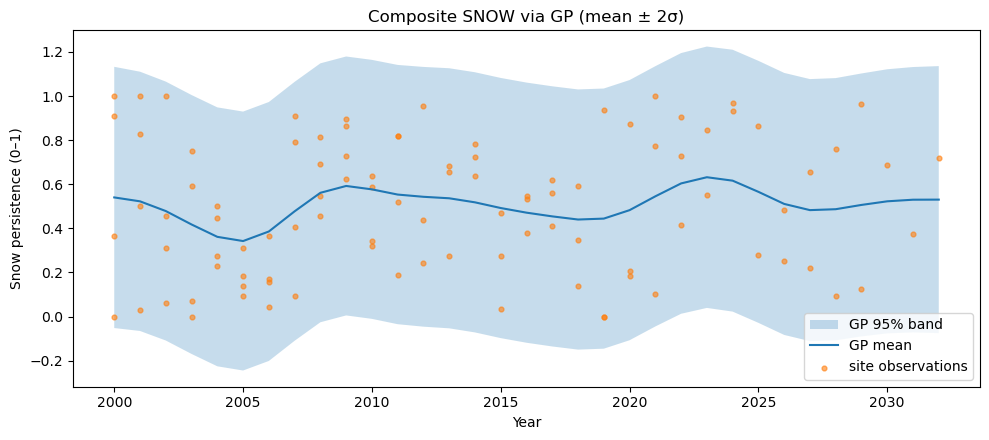

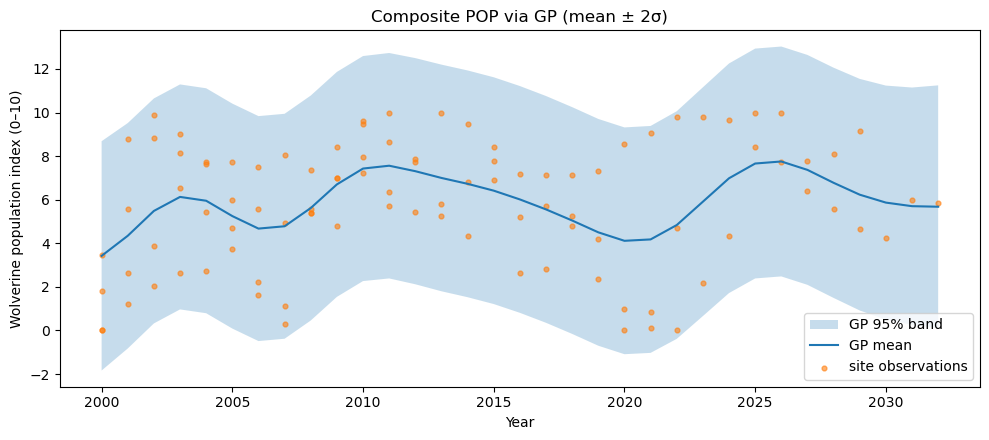

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


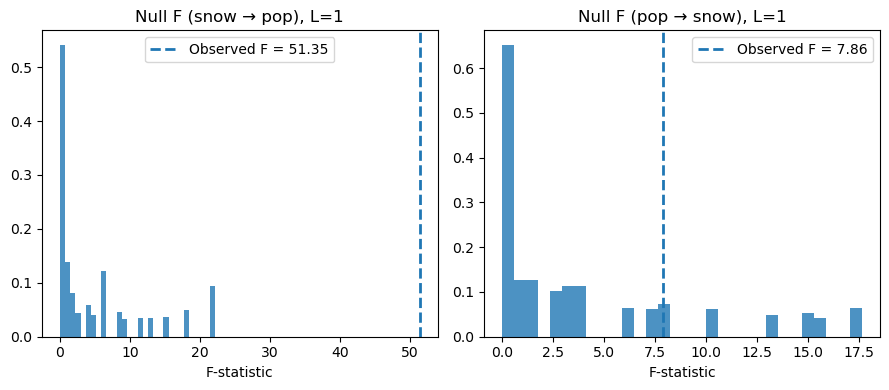

{'lag_L': 1, 'F_snow_to_pop': 51.348985365303086, 'theory_p_snow_to_pop': 6.905191548601579e-08, 'empirical_p_snow_to_pop': np.float64(0.000999000999000999), 'F_pop_to_snow': 7.858211994695181, 'theory_p_pop_to_snow': 0.008927629651196188, 'empirical_p_pop_to_snow': np.float64(0.2017982017982018)}
Significant Granger causality detected: snow → pop


In [31]:
# %%
# Wolverine multi-site short series -> GP composite + Granger (statsmodels) + circular-shift null
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import warnings

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel, DotProduct

# Granger from statsmodels
from statsmodels.tsa.stattools import grangercausalitytests

warnings.filterwarnings("ignore", category=UserWarning)  # silence statsmodels verbosity for small samples

rng = np.random.default_rng(42)

# ------------------------
# 0) Generate synthetic data (your original set-up)
# ------------------------
loc_ids = [f"loc{i+1}" for i in range(4)]
lengths = rng.integers(10, 41, size=4).tolist()  # per-site N in [10,40]
records = []

for loc, n in zip(loc_ids, lengths):
    # Snow(t): AR(1) -> rank-map to [0,1]
    phi = 0.7
    e = rng.normal(0, 0.3, size=n)
    s = np.zeros(n)
    s[0] = rng.normal(0, 1)
    for t in range(1, n):
        s[t] = phi * s[t-1] + e[t]
    snow = (pd.Series(s).rank(method="average").to_numpy() - 1) / (n - 1)

    # Pop(t): AR(1) + Snow(t-1)
    pop = np.zeros(n)
    pop[0] = rng.normal(0, 1)
    for t in range(1, n):
        pop[t] = 0.55 * pop[t-1] + 0.45 * snow[t-1] + rng.normal(0, 0.01)
    pop = (pop - pop.min()) / (pop.max() - pop.min() + 1e-12) * 10

    years = np.arange(2000, 2000 + n)
    for t in range(n):
        records.append({"location": loc, "year": int(years[t]), "snow": float(snow[t]), "pop": float(pop[t])})

df = pd.DataFrame(records).sort_values(["location", "year"]).reset_index(drop=True)

# ------------------------
# 1) GP composites over the union time axis (pool all sites)
# ------------------------
t_min = int(df["year"].min())
t_max = int(df["year"].max())
t_grid = np.arange(t_min, t_max + 1).astype(float).reshape(-1, 1)

def fit_gp(time_col, y_col):
    X = df[[time_col]].astype(float).to_numpy()
    y = df[y_col].to_numpy()
    # Smooth component + tiny linear part + i.i.d. noise; WhiteKernel allows repeated X
    kernel = (
        C(1.0, (1e-2, 1e3)) * RBF(length_scale=5.0, length_scale_bounds=(1.0, 50.0))
        + 0.1 * DotProduct(sigma_0=1.0)
        + WhiteKernel(noise_level=0.05, noise_level_bounds=(1e-5, 1.0))
    )
    gpr = GaussianProcessRegressor(
        kernel=kernel, normalize_y=True, alpha=1e-6, random_state=0, n_restarts_optimizer=3
    )
    gpr.fit(X, y)
    mu, std = gpr.predict(t_grid, return_std=True)
    return gpr, mu, std

gp_snow, snow_mu, snow_std = fit_gp("year", "snow")
gp_pop,  pop_mu,  pop_std  = fit_gp("year", "pop")

comp = pd.DataFrame({
    "year": t_grid.ravel().astype(int),
    "snow_mean": snow_mu,
    "snow_std": snow_std,
    "pop_mean": pop_mu,
    "pop_std": pop_std
})

# ------------------------
# 2) Plot the GP composites with uncertainty (no saving)
# ------------------------
x_year = comp["year"].to_numpy()
snow_mu = comp["snow_mean"].to_numpy(dtype=float)
snow_std = comp["snow_std"].to_numpy(dtype=float)
pop_mu  = comp["pop_mean"].to_numpy(dtype=float)
pop_std = comp["pop_std"].to_numpy(dtype=float)

plt.figure(figsize=(10, 4.5))
plt.title("Composite SNOW via GP (mean ± 2σ)")
plt.fill_between(x_year, snow_mu - 2*snow_std, snow_mu + 2*snow_std, alpha=0.25, label="GP 95% band")
plt.plot(x_year, snow_mu, label="GP mean")
plt.scatter(df["year"], df["snow"], s=12, alpha=0.6, label="site observations")
plt.xlabel("Year"); plt.ylabel("Snow persistence (0–1)")
plt.legend(loc="best"); plt.tight_layout(); plt.show()

plt.figure(figsize=(10, 4.5))
plt.title("Composite POP via GP (mean ± 2σ)")
plt.fill_between(x_year, pop_mu - 2*pop_std, pop_mu + 2*pop_std, alpha=0.25, label="GP 95% band")
plt.plot(x_year, pop_mu, label="GP mean")
plt.scatter(df["year"], df["pop"], s=12, alpha=0.6, label="site observations")
plt.xlabel("Year"); plt.ylabel("Wolverine population index (0–10)")
plt.legend(loc="best"); plt.tight_layout(); plt.show()

# ------------------------
# 3) Granger causality (statsmodels) on z-scored GP means
# ------------------------
# Use lag L=1 to match the DGP (pop_t depends on snow_{t-1}).
L = 1
y_pop  = stats.zscore(comp["pop_mean"].to_numpy(dtype=float))
x_snow = stats.zscore(comp["snow_mean"].to_numpy(dtype=float))

def granger_ssr_ftest(y, x, maxlag=1):
    """
    statsmodels expects an array with columns [y, x]; it tests if x 'Granger-causes' y.
    We extract the SSR-based F-test at the requested lag.
    """
    data = np.column_stack([y, x])
    res = grangercausalitytests(data, maxlag=maxlag, verbose=False)
    # 'ssr_ftest' -> (F, pvalue, df_denom, df_num)
    F, p, _, _ = res[maxlag][0]["ssr_ftest"]
    return float(F), float(p)

F_s2p, p_s2p = granger_ssr_ftest(y_pop, x_snow, maxlag=L)   # snow → pop
F_p2s, p_p2s = granger_ssr_ftest(x_snow, y_pop, maxlag=L)   # pop → snow

# ------------------------
# 4) Empirical null via circular shifts (keep autocorr; break cross-dependence)
# ------------------------
def circular_shift(arr, k):
    if k == 0:
        return arr.copy()
    k = k % len(arr)
    return np.concatenate([arr[-k:], arr[:-k]])

Nnull = 1000
F_null_s2p = np.empty(Nnull)
F_null_p2s = np.empty(Nnull)

for i in range(Nnull):
    k = int(rng.integers(1, len(y_pop)-1))  # avoid 0-shift
    # snow → pop with shifted snow
    F_null_s2p[i], _ = granger_ssr_ftest(y_pop, circular_shift(x_snow, k), maxlag=L)
    # pop → snow with shifted pop
    F_null_p2s[i], _ = granger_ssr_ftest(x_snow, circular_shift(y_pop, k), maxlag=L)

p_emp_s2p = (1 + np.sum(F_null_s2p >= F_s2p)) / (1 + Nnull)
p_emp_p2s = (1 + np.sum(F_null_p2s >= F_p2s)) / (1 + Nnull)

# ------------------------
# 5) Plot null histograms with observed F (no saving)
# ------------------------
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.title(f"Null F (snow → pop), L={L}")
plt.hist(F_null_s2p, bins=30, alpha=0.8, density=True)
plt.axvline(F_s2p, linestyle="--", linewidth=2, label=f"Observed F = {F_s2p:.2f}")
plt.xlabel("F-statistic"); plt.legend()

plt.subplot(1,2,2)
plt.title(f"Null F (pop → snow), L={L}")
plt.hist(F_null_p2s, bins=30, alpha=0.8, density=True)
plt.axvline(F_p2s, linestyle="--", linewidth=2, label=f"Observed F = {F_p2s:.2f}")
plt.xlabel("F-statistic"); plt.legend()

plt.tight_layout(); plt.show()

# ------------------------
# 6) Print summary
# ------------------------
print({
    "lag_L": L,
    "F_snow_to_pop": F_s2p,
    "theory_p_snow_to_pop": p_s2p,
    "empirical_p_snow_to_pop": p_emp_s2p,
    "F_pop_to_snow": F_p2s,
    "theory_p_pop_to_snow": p_p2s,
    "empirical_p_pop_to_snow": p_emp_p2s,
})

# print the significant test results
if p_emp_s2p < 0.05:
    print("Significant Granger causality detected: snow → pop")
if p_emp_p2s < 0.05:
    print("Significant Granger causality detected: pop → snow")


/opt/anaconda3/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


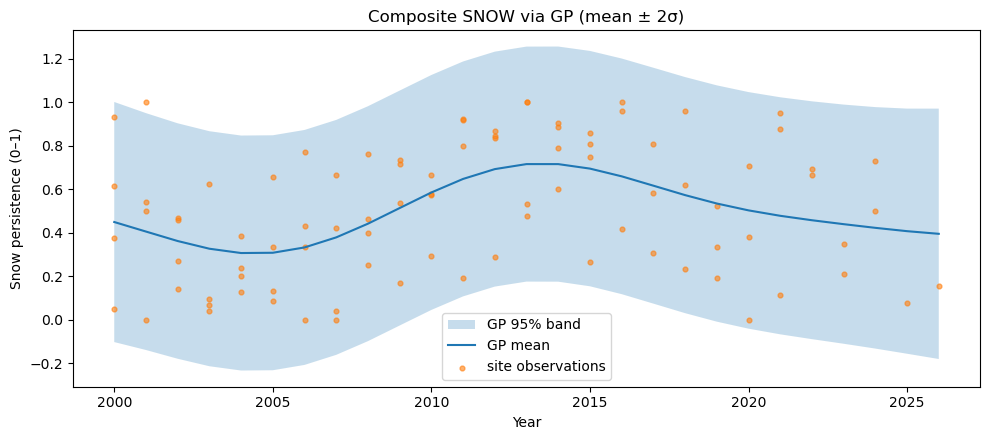

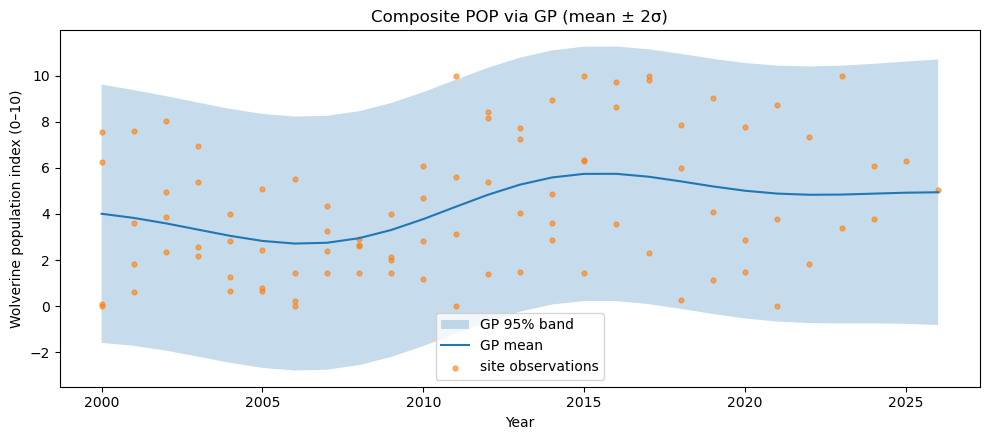

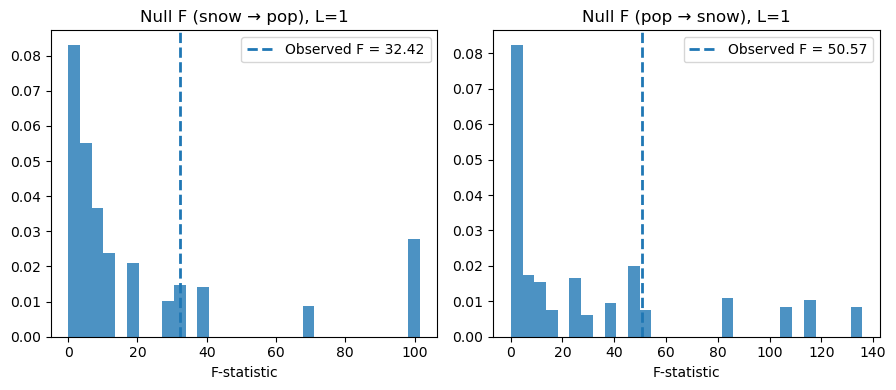

{'lag_L': 1,
 'F_snow_to_pop': 32.42103655820873,
 'theory_p_snow_to_pop': np.float64(8.487574881103532e-06),
 'empirical_p_snow_to_pop': np.float64(0.17282717282717283),
 'F_pop_to_snow': 50.565846882533755,
 'theory_p_pop_to_snow': np.float64(3.0427278919947543e-07),
 'empirical_p_pop_to_snow': np.float64(0.2077922077922078),
 'df_snow_to_pop': (1, 23),
 'df_pop_to_snow': (1, 23)}

In [14]:
# %%
# Wolverine multi-site short series -> GP composite + Granger test with null surrogates
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel, DotProduct
from scipy import stats

rng = np.random.default_rng(42)

# ------------------------
# 0) Generate synthetic data (as provided)
# ------------------------
loc_ids = [f"loc{i+1}" for i in range(4)]
lengths = rng.integers(15, 31, size=4).tolist()  # per-site N in [15,30]
records = []

for loc, n in zip(loc_ids, lengths):
    # Snow(t): AR(1) -> rank-map to [0,1]
    phi = 0.7
    e = rng.normal(0, 0.3, size=n)
    s = np.zeros(n)
    s[0] = rng.normal(0, 1)
    for t in range(1, n):
        s[t] = phi * s[t-1] + e[t]
    snow = (pd.Series(s).rank(method="average").to_numpy() - 1) / (n - 1)

    # Pop(t): AR(1) + Snow(t-1)
    pop = np.zeros(n)
    pop[0] = rng.normal(0, 1)
    for t in range(1, n):
        pop[t] = 0.55 * pop[t-1] + 0.45 * snow[t-1] + rng.normal(0, 0.2)
    pop = (pop - pop.min()) / (pop.max() - pop.min() + 1e-12) * 10

    years = np.arange(2000, 2000 + n)
    for t in range(n):
        records.append({"location": loc, "year": int(years[t]), "snow": float(snow[t]), "pop": float(pop[t])})

df = pd.DataFrame(records).sort_values(["location", "year"]).reset_index(drop=True)
df.to_csv("wolverine_synth_multispatial.csv", index=False)

# ------------------------
# 1) Fit GP composites for snow and pop across all sites
#    We pool all site observations at the same year; GP handles repeated X with WhiteKernel.
# ------------------------
t_min = int(df["year"].min())
t_max = int(df["year"].max())
t_grid = np.arange(t_min, t_max + 1).astype(float).reshape(-1, 1)

def fit_gp(time_col, y_col):
    X = df[[time_col]].astype(float).to_numpy()
    y = df[y_col].to_numpy()
    # Kernel: smooth component + small linear trend + noise
    kernel = C(1.0, (1e-2, 1e3)) * RBF(length_scale=5.0, length_scale_bounds=(1.0, 50.0)) \
             + 0.1 * DotProduct(sigma_0=1.0) + WhiteKernel(noise_level=0.05, noise_level_bounds=(1e-5, 1.0))
    gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True, alpha=1e-6, random_state=0, n_restarts_optimizer=3)
    gpr.fit(X, y)
    mu, std = gpr.predict(t_grid, return_std=True)
    return gpr, mu, std

gp_snow, snow_mu, snow_std = fit_gp("year", "snow")
gp_pop,  pop_mu,  pop_std  = fit_gp("year", "pop")

comp = pd.DataFrame({
    "year": t_grid.ravel().astype(int),
    "snow_mean": snow_mu,
    "snow_std": snow_std,
    "pop_mean": pop_mu,
    "pop_std": pop_std
})
comp.to_csv("composite_gp_pop_snow.csv", index=False)

# ------------------------
# 2) Plots: GP composites with uncertainty
# ------------------------
plt.figure(figsize=(10, 4.5))
plt.title("Composite SNOW via GP (mean ± 2σ)")
plt.fill_between(comp["year"], comp["snow_mean"] - 2*comp["snow_std"], comp["snow_mean"] + 2*comp["snow_std"], alpha=0.25, label="GP 95% band")
plt.plot(comp["year"], comp["snow_mean"], label="GP mean")
# plot raw points
plt.scatter(df["year"], df["snow"], s=12, alpha=0.6, label="site observations")
plt.xlabel("Year")
plt.ylabel("Snow persistence (0–1)")
plt.legend(loc="best")
plt.tight_layout()
# plt.savefig("/mnt/data/plot_gp_snow.png", dpi=180)
plt.show()

plt.figure(figsize=(10, 4.5))
plt.title("Composite POP via GP (mean ± 2σ)")
plt.fill_between(comp["year"], comp["pop_mean"] - 2*comp["pop_std"], comp["pop_mean"] + 2*comp["pop_std"], alpha=0.25, label="GP 95% band")
plt.plot(comp["year"], comp["pop_mean"], label="GP mean")
plt.scatter(df["year"], df["pop"], s=12, alpha=0.6, label="site observations")
plt.xlabel("Year")
plt.ylabel("Wolverine population index (0–10)")
plt.legend(loc="best")
plt.tight_layout()
# plt.savefig("/mnt/data/plot_gp_pop.png", dpi=180)
plt.show()

# ------------------------
# 3) Granger causality on composite means
#    We'll use lag=1 (matches the data generating process), with z-scored series.
#    Test snow -> pop and pop -> snow.
#    Also build a null distribution by random circular shifts (preserves autocorr).
# ------------------------
def prepare_lagged(y, x, L=1):
    """
    Build design matrices for Granger test with lag L.
    Returns arrays for unrestricted and restricted OLS:
    y_t, X_u (includes y-lags and x-lags), X_r (only y-lags). Both with an intercept column.
    """
    y = np.asarray(y, float)
    x = np.asarray(x, float)
    T = len(y)
    rows = []
    for t in range(L, T):
        y_t = y[t]
        y_lags = [y[t - l] for l in range(1, L+1)]
        x_lags = [x[t - l] for l in range(1, L+1)]
        rows.append((y_t, y_lags, x_lags))
    Y = np.array([r[0] for r in rows])
    Ylags = np.array([r[1] for r in rows])
    Xlags = np.array([r[2] for r in rows])
    # Add intercept
    X_u = np.column_stack([np.ones(len(Y)), Ylags, Xlags])
    X_r = np.column_stack([np.ones(len(Y)), Ylags])
    return Y, X_u, X_r

def ols_rss(Y, X):
    # OLS via QR; return RSS and df
    beta, _, _, _ = np.linalg.lstsq(X, Y, rcond=None)
    resid = Y - X @ beta
    rss = float(resid.T @ resid)
    dof = len(Y) - X.shape[1]
    return rss, dof

def granger_F(y, x, L=1):
    Y, X_u, X_r = prepare_lagged(y, x, L=L)
    rss_u, dof_u = ols_rss(Y, X_u)
    rss_r, dof_r = ols_rss(Y, X_r)
    d_params = X_u.shape[1] - X_r.shape[1]  # equals L (x-lags added)
    # F statistic
    F = ((rss_r - rss_u) / d_params) / (rss_u / dof_u)
    p = stats.f.sf(F, d_params, dof_u)
    return F, p, (d_params, dof_u)

# z-score composite means for stationarity-ish behavior
y_pop  = stats.zscore(comp["pop_mean"].to_numpy())
x_snow = stats.zscore(comp["snow_mean"].to_numpy())

L = 1
F_s2p, p_s2p, df_s2p = granger_F(y_pop, x_snow, L=L)  # snow -> pop
F_p2s, p_p2s, df_p2s = granger_F(x_snow, y_pop, L=L)  # pop -> snow

# ------------------------
# 4) Null distribution via circular shifts
# ------------------------
def circular_shift(arr, k):
    if k == 0:
        return arr.copy()
    k = k % len(arr)
    return np.concatenate([arr[-k:], arr[:-k]])

Nnull = 1000
F_null_s2p = np.empty(Nnull)
F_null_p2s = np.empty(Nnull)

for i in range(Nnull):
    k = rng.integers(1, len(y_pop)-1)  # avoid 0 shift
    x_perm = circular_shift(x_snow, int(k))
    # snow -> pop with shifted snow
    F_null_s2p[i], _, _ = granger_F(y_pop, x_perm, L=L)
    # pop -> snow with shifted pop
    y_perm = circular_shift(y_pop, int(k))
    F_null_p2s[i], _, _ = granger_F(x_snow, y_perm, L=L)

p_emp_s2p = (1 + np.sum(F_null_s2p >= F_s2p)) / (1 + Nnull)
p_emp_p2s = (1 + np.sum(F_null_p2s >= F_p2s)) / (1 + Nnull)

# ------------------------
# 5) Plot null histograms with observed F
# ------------------------
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.title(f"Null F (snow → pop), L={L}")
plt.hist(F_null_s2p, bins=30, alpha=0.8, density=True)
plt.axvline(F_s2p, linestyle="--", linewidth=2, label=f"Observed F = {F_s2p:.2f}")
plt.xlabel("F-statistic")
plt.legend()

plt.subplot(1,2,2)
plt.title(f"Null F (pop → snow), L={L}")
plt.hist(F_null_p2s, bins=30, alpha=0.8, density=True)
plt.axvline(F_p2s, linestyle="--", linewidth=2, label=f"Observed F = {F_p2s:.2f}")
plt.xlabel("F-statistic")
plt.legend()

plt.tight_layout()
# plt.savefig("/mnt/data/plot_granger_nulls.png", dpi=180)
plt.show()

# ------------------------
# 6) Print summary
# ------------------------
summary = {
    "lag_L": L,
    "F_snow_to_pop": F_s2p,
    "theory_p_snow_to_pop": p_s2p,
    "empirical_p_snow_to_pop": p_emp_s2p,
    "F_pop_to_snow": F_p2s,
    "theory_p_pop_to_snow": p_p2s,
    "empirical_p_pop_to_snow": p_emp_p2s,
    "df_snow_to_pop": df_s2p,
    "df_pop_to_snow": df_p2s,
}
summary


Saved synthetic data -> wolverine_synth_multispatial.csv
Lengths by site: {'loc1': 16, 'loc2': 27, 'loc3': 25, 'loc4': 22}
Pooled rows: X->Y = 82, Y->X = 82

Saved -> spatial_ccm_summary.csv
 LibSize  rho_obs_X_to_Y  rho_obs_Y_to_X  boot_lo_X_to_Y  boot_hi_X_to_Y  boot_lo_Y_to_X  boot_hi_Y_to_X  null_lo_X_to_Y  null_hi_X_to_Y  null_lo_Y_to_X  null_hi_Y_to_X  pval_X_to_Y  pval_Y_to_X
      16           0.235           0.276          -0.036           0.405           0.022           0.474          -0.102           0.140          -0.166           0.171          0.0          0.0
      22           0.244           0.218          -0.045           0.424           0.029           0.503          -0.061           0.102          -0.184           0.160          0.0          0.0
      27           0.230           0.223          -0.047           0.438           0.008           0.509          -0.100           0.142          -0.209           0.155          0.0          0.0
      32           0.207     

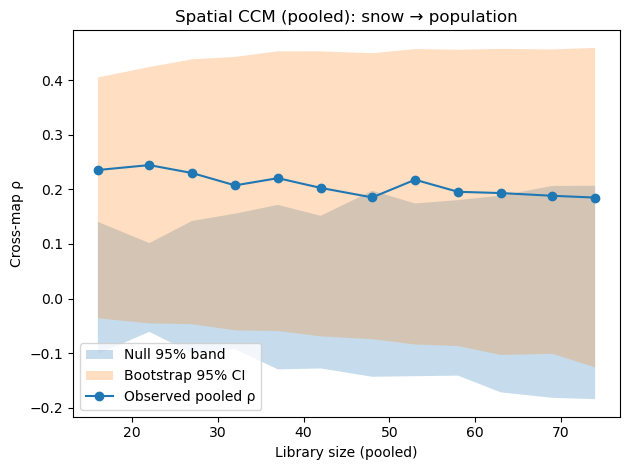

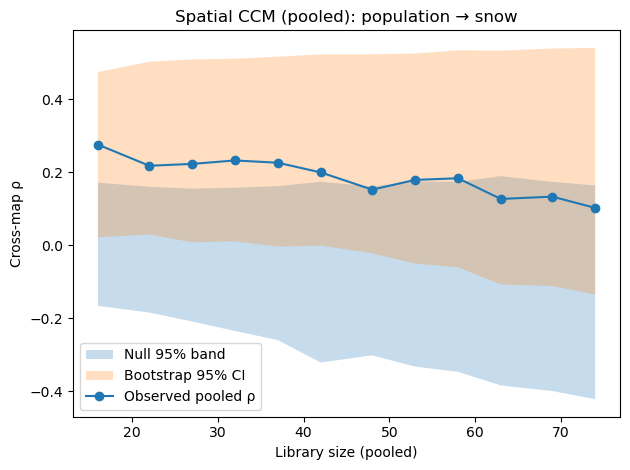

In [9]:
# run_spatial_ccm_pooled_bootstrap_tau_neg1.py
# ------------------------------------------------------------
# True spatial CCM with pooled common manifold, site-bootstrap, and nulls.
# (Checked against pyEDM API: embedded=True multivariate block, noTime=True, Tp=0)
# ------------------------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyEDM

# ------------------------
# 0) Generate synthetic data
# ------------------------
rng = np.random.default_rng(42)

loc_ids = [f"loc{i+1}" for i in range(4)]
lengths = rng.integers(15, 31, size=4).tolist()  # per-site N in [15,30]
records = []

for loc, n in zip(loc_ids, lengths):
    # Snow(t): AR(1) -> rank-map to [0,1]
    phi = 0.7
    e = rng.normal(0, 0.3, size=n)
    s = np.zeros(n)
    s[0] = rng.normal(0, 1)
    for t in range(1, n):
        s[t] = phi * s[t-1] + e[t]
    snow = (pd.Series(s).rank(method="average").to_numpy() - 1) / (n - 1)

    # Pop(t): AR(1) + Snow(t-1)
    pop = np.zeros(n)
    pop[0] = rng.normal(0, 1)
    for t in range(1, n):
        pop[t] = 0.55 * pop[t-1] + 0.45 * snow[t-1] + rng.normal(0, 0.2)
    pop = (pop - pop.min()) / (pop.max() - pop.min() + 1e-12) * 10

    years = np.arange(2000, 2000 + n)
    for t in range(n):
        records.append({"location": loc, "year": int(years[t]), "snow": float(snow[t]), "pop": float(pop[t])})

df = pd.DataFrame(records).sort_values(["location", "year"]).reset_index(drop=True)
df.to_csv("wolverine_synth_multispatial.csv", index=False)
print("Saved synthetic data -> wolverine_synth_multispatial.csv")
print("Lengths by site:", {loc: n for loc, n in zip(loc_ids, lengths)})

# ------------------------
# 1) Spatial CCM settings
# ------------------------
E = 3          # embedding dimension = number of lag columns in the multivariate block
TAU = -1       # backward lag; we use abs(TAU) to get t, t-1, t-2, ...
LAG = 1        # biological lag: X_{t-1} -> Y_t
SAMPLES = 20  # random library resamples per LibSize within pyEDM.CCM
RNG_SEED = 123

# Pooled library sizes as proportions of pooled N (after embedding)
# P_GRID = np.linspace(0.2, 0.9, 12)
P_GRID = np.array([0.2, 0.35, 0.5, 0.65, 0.8, 0.9])


def pooled_libsizes(N_pooled, E, p_grid):
    min_L = max(E + 2, 10)
    max_L = max(min_L + 1, N_pooled - 3)
    L = np.clip(np.rint(p_grid * N_pooled).astype(int), min_L, max_L)
    L = np.unique(L)
    if L.size == 0:
        L = np.array([max(min_L, min(max_L, N_pooled // 2))])
    return L

# ------------------------
# 2) Build pooled embeddings (NO cross-site lags)
# ------------------------
def embed_within_site(g, E=E, tau=TAU, lag=LAG, y="pop", x="snow", direction="x_to_y"):
    """
    TAU<0 => lags are t, t-1, ..., t-(E-1). No cross-site lags.
    direction:
      - "x_to_y": columns = Y lags; target = X at t-lag
      - "y_to_x": columns = X lags; target = Y at t-lag
    """
    g = g.sort_values("year").reset_index(drop=True).copy()
    N = len(g)
    step = abs(int(tau))
    start = max(lag, (E - 1) * step)

    rows = []
    if direction == "x_to_y":
        for t in range(start, N):
            cols = {f"Y_lag{k}": g[y].iloc[t - k * step] for k in range(E)}
            cols["target"] = g[x].iloc[t - lag]
            cols["site"] = g["location"].iloc[0]
            rows.append(cols)
    elif direction == "y_to_x":
        for t in range(start, N):
            cols = {f"Y_lag{k}": g[x].iloc[t - k * step] for k in range(E)}  # reuse names
            cols["target"] = g[y].iloc[t - lag]
            cols["site"] = g["location"].iloc[0]
            rows.append(cols)
    else:
        raise ValueError("direction must be 'x_to_y' or 'y_to_x'")

    return pd.DataFrame(rows)

def build_pooled(df, direction="x_to_y", E=E, tau=TAU, lag=LAG):
    pieces = [embed_within_site(g, E=E, tau=tau, lag=lag, direction=direction)
              for _, g in df.groupby("location")]
    pooled = pd.concat(pieces, ignore_index=True)
    col_list = [f"Y_lag{k}" for k in range(E)]
    col_str = " ".join(col_list)
    return pooled, col_list, col_str

# Build pooled data for both directions
pooled_xy, _, cols_xy_str = build_pooled(df, direction="x_to_y", E=E, tau=TAU, lag=LAG)  # snow -> pop (true)
pooled_yx, _, cols_yx_str = build_pooled(df, direction="y_to_x", E=E, tau=TAU, lag=LAG)  # pop -> snow (false)
print(f"Pooled rows: X->Y = {len(pooled_xy)}, Y->X = {len(pooled_yx)}")

# ------------------------
# 3) CCM on a pre-embedded pooled dataset
# ------------------------
def run_ccm_pooled(pooled_df, col_str, target_col="target",
                   lib_sizes=None, samples=SAMPLES, seed=RNG_SEED):
    if lib_sizes is None:
        lib_sizes = pooled_libsizes(len(pooled_df), E, P_GRID)
    libSizes_str = " ".join(map(str, lib_sizes))

    out = pyEDM.CCM(
        dataFrame=pooled_df,
        columns=col_str,            # multivariate block of lag columns
        target=target_col,          # cross-mapped variable (aligned lag)
        embedded=True,              # pre-embedded (multivariate) block
        noTime=True,                # no explicit time column provided
        Tp=0,                       # contemporaneous prediction (lag handled in target)
        E=E,                        # must match number of lag columns when embedded=True
        sample=samples,
        includeData=False,
        ignoreNan=True,
        seed=seed,
        libSizes=libSizes_str
    )

    # pyEDM returns either ['LibSize','rho'] or ['LibSize', '<col>:<tgt>', '<tgt>:<col>']
    if "rho" in out.columns:
        L_used = out["LibSize"].to_numpy()
        rho = out["rho"].to_numpy()
    else:
        L_used = out.iloc[:, 0].to_numpy()
        rho = out.iloc[:, 1].to_numpy()

    rho_map = dict(zip(L_used, rho))
    rho_vec = np.array([rho_map.get(L, np.nan) for L in lib_sizes])
    return lib_sizes, rho_vec

# Observed (single pooled run, no resampling)
L_obs_xy, rho_obs_xy = run_ccm_pooled(pooled_xy, cols_xy_str)
L_obs_yx, rho_obs_yx = run_ccm_pooled(pooled_yx, cols_yx_str)
assert np.array_equal(L_obs_xy, L_obs_yx), "LibSize grids differ unexpectedly."
LIB_GRID = L_obs_xy  # master grid used for alignment later

# ------------------------
# 4) Dewdrop bootstrap (resample sites) — FILTER to subset of LIB_GRID
# ------------------------
def bootstrap_spatial(df, direction, lib_grid, B=400, seed=RNG_SEED):
    rng = np.random.default_rng(seed)
    sites = df["location"].unique().tolist()
    curves = []

    min_allowed = max(E + 2, 10)

    for b in range(B):
        boot_sites = rng.choice(sites, size=len(sites), replace=True)
        boot_df = pd.concat([df[df["location"] == s] for s in boot_sites], ignore_index=True)

        pooled_b, _, cols_b_str = build_pooled(boot_df, direction=direction, E=E, tau=TAU, lag=LAG)
        max_allowed = len(pooled_b) - 3
        if max_allowed < min_allowed:
            continue

        # Only lib sizes present in lib_grid AND feasible for this bootstrap
        L_b = lib_grid[(lib_grid >= min_allowed) & (lib_grid <= max_allowed)]
        if L_b.size == 0:
            continue

        L_used, rho_b = run_ccm_pooled(pooled_b, cols_b_str, lib_sizes=L_b, seed=seed + b)

        rho_full = np.full(lib_grid.shape, np.nan, dtype=float)
        idx = {int(L): j for j, L in enumerate(lib_grid)}
        for L, r in zip(L_used, rho_b):
            j = idx.get(int(L), None)
            if j is not None:
                rho_full[j] = r
        curves.append(rho_full)

    curves = np.vstack(curves) if len(curves) else np.full((1, len(lib_grid)), np.nan)
    return curves

boot_xy = bootstrap_spatial(df, direction="x_to_y", lib_grid=LIB_GRID, B=400, seed=RNG_SEED)
boot_yx = bootstrap_spatial(df, direction="y_to_x", lib_grid=LIB_GRID, B=400, seed=RNG_SEED)

boot_lo_xy = np.nanquantile(boot_xy, 0.025, axis=0)
boot_hi_xy = np.nanquantile(boot_xy, 0.975, axis=0)
boot_lo_yx = np.nanquantile(boot_yx, 0.025, axis=0)
boot_hi_yx = np.nanquantile(boot_yx, 0.975, axis=0)

# ------------------------
# 5) Circular-shift null (per site) — FILTER to subset of LIB_GRID
# ------------------------
def circular_shift(arr, k):
    k = int(k) % len(arr)
    return np.concatenate([arr[-k:], arr[:-k]]) if k else arr

def null_curves(df, direction, lib_grid, N_perm=100, seed=RNG_SEED):
    rng = np.random.default_rng(seed)
    curves = []
    min_allowed = max(E + 2, 10)

    for i in range(N_perm):
        cause_col = "snow" if direction == "x_to_y" else "pop"

        parts = []
        for _, g in df.groupby("location", sort=False):
            g = g.sort_values("year").reset_index(drop=True).copy()
            if len(g) > 1:
                k = rng.integers(1, len(g))
                g[cause_col] = circular_shift(g[cause_col].to_numpy(), k)
            parts.append(g)
        df_shift = pd.concat(parts, ignore_index=True)

        pooled_i, _, cols_str_i = build_pooled(df_shift, direction=direction, E=E, tau=TAU, lag=LAG)
        max_allowed = len(pooled_i) - 3
        if max_allowed < min_allowed:
            continue

        L_i = lib_grid[(lib_grid >= min_allowed) & (lib_grid <= max_allowed)]
        if L_i.size == 0:
            continue

        L_used, rho_i = run_ccm_pooled(pooled_i, cols_str_i, lib_sizes=L_i, seed=seed + i)

        rho_full = np.full(lib_grid.shape, np.nan, dtype=float)
        idx = {int(L): j for j, L in enumerate(lib_grid)}
        for L, r in zip(L_used, rho_i):
            j = idx.get(int(L), None)
            if j is not None:
                rho_full[j] = r
        curves.append(rho_full)

    curves = np.vstack(curves) if len(curves) else np.full((1, len(lib_grid)), np.nan)
    return curves

N_NULL = 10
null_xy = null_curves(df, direction="x_to_y", lib_grid=LIB_GRID, N_perm=N_NULL, seed=RNG_SEED + 1000)
null_yx = null_curves(df, direction="y_to_x", lib_grid=LIB_GRID, N_perm=N_NULL, seed=RNG_SEED + 2000)

null_lo_xy = np.nanquantile(null_xy, 0.025, axis=0)
null_hi_xy = np.nanquantile(null_xy, 0.975, axis=0)
null_lo_yx = np.nanquantile(null_yx, 0.025, axis=0)
null_hi_yx = np.nanquantile(null_yx, 0.975, axis=0)

def pvals_vs_null(obs, null_mat):
    return np.array([(null_mat[:, j] >= obs[j]).mean() for j in range(len(obs))])

pval_xy = pvals_vs_null(rho_obs_xy, null_xy)
pval_yx = pvals_vs_null(rho_obs_yx, null_yx)

# ------------------------
# 6) Save summary table
# ------------------------
summary = pd.DataFrame({
    "LibSize": LIB_GRID,
    "rho_obs_X_to_Y": rho_obs_xy,
    "rho_obs_Y_to_X": rho_obs_yx,
    "boot_lo_X_to_Y": boot_lo_xy,
    "boot_hi_X_to_Y": boot_hi_xy,
    "boot_lo_Y_to_X": boot_lo_yx,
    "boot_hi_Y_to_X": boot_hi_yx,
    "null_lo_X_to_Y": null_lo_xy,
    "null_hi_X_to_Y": null_hi_xy,
    "null_lo_Y_to_X": null_lo_yx,
    "null_hi_Y_to_X": null_hi_yx,
    "pval_X_to_Y": pval_xy,
    "pval_Y_to_X": pval_yx
})
summary.to_csv("spatial_ccm_summary.csv", index=False)
print("\nSaved -> spatial_ccm_summary.csv")
print(summary.round(3).to_string(index=False))

# ------------------------
# 7) Plots
# ------------------------
def plot_ccm(L, obs, boot_lo, boot_hi, null_lo, null_hi, title):
    plt.figure()
    plt.fill_between(L, null_lo, null_hi, alpha=0.25, label="Null 95% band")
    plt.fill_between(L, boot_lo, boot_hi, alpha=0.25, label="Bootstrap 95% CI")
    plt.plot(L, obs, marker="o", label="Observed pooled ρ")
    plt.xlabel("Library size (pooled)")
    plt.ylabel("Cross-map ρ")
    plt.title(title)
    plt.legend()
    plt.tight_layout()

plot_ccm(LIB_GRID, rho_obs_xy, boot_lo_xy, boot_hi_xy, null_lo_xy, null_hi_xy,
         title="Spatial CCM (pooled): snow → population")
plot_ccm(LIB_GRID, rho_obs_yx, boot_lo_yx, boot_hi_yx, null_lo_yx, null_hi_yx,
         title="Spatial CCM (pooled): population → snow")

plt.show()


In [6]:
# run_multispatial_ccm_visual_Tp1.py
# ------------------------------------------------------------
# Purpose
#   - Simulate 4 short, noisy site time series where *snow(t)* causally
#     influences *population(t+1)*.
#   - Run CCM at each site using pyEDM across a grid of library sizes.
#   - Pseudo "spatial CCM": pool site-wise CCM results (mean across sites).
#   - Create a circular-shift null to get 95% bands.
#   - Plot observed pooled CCM curves vs null bands for both directions.
#
# Key simplification vs previous version:
#   - We set CCM's Tp=1 (one-step lead) so *cause precedes effect* is handled
#     directly by the algorithm; no manual time-shifting of the series.
#
# Reading the plots:
#   - If snow → population is causal, the pooled ρ curve should rise with
#     library size and sit above the null band (esp. at larger libraries).
#   - The reverse direction (population → snow) should usually stay within band.
# ------------------------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyEDM

# ------------------------
# 0) Generate synthetic data
# ------------------------
# We simulate four locations (replicates). Each has an annual time series with
# random length between 15 and 30. Two variables per site:
#   - snow_persist_Apr24_May15 (0..1): fraction-of-days-with-snow proxy
#   - wolverine_density (0..10): standardized density proxy
#
# Data-generating process (per site):
#   1) Snow(t) follows an AR(1) with phi ~ 0.7 + noise; then rank-mapped to 0..1
#      so it behaves like a fraction but keeps realistic autocorrelation.
#   2) Population(t) depends on:
#         a) its own AR(1) memory, and
#         b) Snow at the *same time index* (snow[t])  <-- important design choice
#      Because CCM will use Tp=1, it will test whether the state of Snow at time t
#      contains information about Population at time t+1, which matches the
#      ecological idea "late-spring snow in year t influences next year's pop."
#
# Why choose snow[t] (not snow[t-1]) in the generator?
#   - We want the *true* biological lag to be one year. In CCM with Tp=1, the
#     library built at time t is evaluated against the target at t+1. So if
#     Population(t+1) is a function of Snow(t), CCM with Tp=1 should detect it.
#   - This lets us remove any manual alignment/lag-shifting code.

rng = np.random.default_rng(42)

loc_ids = [f"loc{i+1}" for i in range(4)]
lengths = rng.integers(15, 31, size=4).tolist()  # per-site N in [15,30]
records = []

for loc, n in zip(loc_ids, lengths):
    # ---- Snow(t): AR(1) then rank-map to 0..1 ----
    phi = 0.7
    e = rng.normal(0, 0.3, size=n)         # noise
    s = np.zeros(n)
    s[0] = rng.normal(0, 1)
    for t in range(1, n):
        s[t] = phi * s[t-1] + e[t]

    # Rank-map snow to [0,1] to emulate a "fraction" (monotonic transform):
    ranks = pd.Series(s).rank(method="average").to_numpy()
    snow = (ranks - 1) / (n - 1)

    # ---- Population(t): AR(1) + causal input from Snow(t) ----
    # This means Population at *t+1* depends on Snow at *t*,
    # which is exactly what CCM with Tp=1 will test.
    pop = np.zeros(n)
    pop[0] = rng.normal(0, 1)
    for t in range(1, n):
        pop[t] = 0.55 * pop[t-1] + 0.45 * snow[t] + rng.normal(0, 0.2)

    # Scale population to a friendly 0..10 range (purely cosmetic)
    pop = (pop - pop.min()) / (pop.max() - pop.min() + 1e-9) * 10

    years = np.arange(2000, 2000 + n)
    for t in range(n):
        records.append({
            "location": loc,
            "year": int(years[t]),
            "snow_persist_Apr24_May15": float(snow[t]),
            "wolverine_density": float(pop[t]),
        })

df = pd.DataFrame(records)
df.to_csv("wolverine_synth_multispatial.csv", index=False)
print("Saved synthetic data -> wolverine_synth_multispatial.csv")
print("Lengths by site:", {loc: n for loc, n in zip(loc_ids, lengths)})

# ------------------------
# 1) CCM settings
# ------------------------
# E   : embedding dimension (state-space dimension). Try 2..5 in practice.
# TAU : embedding time shift (pyEDM default when -1). For annual data, default is OK.
# Tp  : prediction interval. We set Tp=1 so *cause precedes effect* is encoded
#       directly in the CCM call (no manual time-shifting needed).
# SAMPLES: number of random library resamples per lib size (bootstrap within CCM).
E = 3
TAU = -1
TP = 1            # <-- core simplification: test Snow(t) → Pop(t+1) inside CCM
SAMPLES = 200
RNG_SEED = 123

# Use a fixed proportion grid of library sizes (same proportions across sites).
# Each site's integer library sizes are N_site * P_GRID (clipped to valid range).
P_GRID = np.linspace(0.4, 0.9, 8)  # 0.40, 0.47, ..., 0.90

def libsizes_from_proportions(N, E, p_grid):
    """Convert proportions to integer library sizes for a site of length N,
    clipped to [E+2, N-3] so CCM has enough points to embed & validate."""
    L = np.clip(np.rint(p_grid * N).astype(int), E + 2, max(E + 2, N - 3))
    L = np.unique(L)  # remove duplicates from rounding/clipping
    if L.size == 0:
        L = np.array([max(E + 2, min(N - 3, max(E + 3, N // 2)))])
    return L

def ccm_site_with_pgrid(site_df, p_grid=P_GRID, E=E, tau=TAU, Tp=TP,
                        samples=SAMPLES, seed=RNG_SEED):
    """Run CCM for one site across a fixed grid of library-size proportions.

    What CCM does conceptually:
      - Builds an embedding of the 'columns' series (here, Snow) in dimension E.
      - Uses nearest neighbors on that manifold to *cross-map* the 'target'
        series (here, Population) at the chosen Tp (Tp=1 tests Snow(t) → Pop(t+1)).
      - Repeats for increasing library sizes (how many points we allow in the
        embedding library). If Snow truly drives Pop, cross-map correlation ρ
        should *increase with library size* (convergence).

    Returns arrays of ρ aligned to the proportion grid for both directions:
      rho_s2p: Snow → Pop (expected to be strong)
      rho_p2s: Pop  → Snow (should be weak in this synthetic setup)
    """
    # Prepare data for pyEDM (two columns only; no explicit time column needed).
    data = site_df[["snow_persist_Apr24_May15", "wolverine_density"]].copy()
    N = len(data)

    # Integer library sizes for this site
    Ls = libsizes_from_proportions(N, E, p_grid)
    libSizes_str = " ".join(map(str, Ls))

    # Run CCM once for all L
    out = pyEDM.CCM(
        dataFrame=data,
        columns="snow_persist_Apr24_May15",   # library variable (Snow)
        target="wolverine_density",           # cross-mapped target (Pop)
        libSizes=libSizes_str,
        E=E, tau=tau, Tp=Tp,
        sample=samples,                       # random library resamples per L
        embedded=False, noTime=True,
        includeData=False, ignoreNan=True,
        seed=seed
    )

    # pyEDM returns 3 columns: [LibSize, rho(Snow→Pop), rho(Pop→Snow)]
    L_used = out.iloc[:, 0].to_numpy()
    rho_s2p_map = dict(zip(L_used, out.iloc[:, 1].to_numpy()))
    rho_p2s_map = dict(zip(L_used, out.iloc[:, 2].to_numpy()))

    # Map back to our fixed p_grid (some props may duplicate after rounding)
    intended_L = np.rint(p_grid * N).astype(int)
    intended_L = np.clip(intended_L, E + 2, max(E + 2, N - 3))

    rho_s2p = np.array([rho_s2p_map.get(L, np.nan) for L in intended_L])
    rho_p2s = np.array([rho_p2s_map.get(L, np.nan) for L in intended_L])

    return {"L_per_site": intended_L, "rho_s2p": rho_s2p, "rho_p2s": rho_p2s}

# Run CCM per site (no manual alignment needed thanks to Tp=1)
site_curves = {}
for loc, g in df.groupby("location"):
    g = g.sort_values("year").reset_index(drop=True).copy()
    site_curves[loc] = ccm_site_with_pgrid(g)

def pooled_curve(site_curves, key="rho_s2p"):
    """Mean across sites at each grid point (ignoring NaNs)."""
    M = np.vstack([curv[key] for curv in site_curves.values()])
    return np.nanmean(M, axis=0)

# Observed pooled CCM curves (our 'spatial CCM' analogue)
obs_pooled_s2p = pooled_curve(site_curves, "rho_s2p")
obs_pooled_p2s = pooled_curve(site_curves, "rho_p2s")

# ------------------------
# 2) Null distributions (circular shifts), both directions
# ------------------------
# The null preserves each site's autocorrelation & distribution but destroys
# the *timing alignment* between Snow and Population by circularly shifting Snow.
# We recompute pooled CCM curves under the null many times to form 95% bands.
def circular_shift(arr, k):
    k = int(k) % len(arr)
    return np.concatenate([arr[-k:], arr[:-k]]) if k else arr

def null_run(df, p_grid=P_GRID, seed=RNG_SEED):
    rng = np.random.default_rng(seed)
    null_site_curves = {}
    for loc, g in df.groupby("location"):
        g = g.sort_values("year").reset_index(drop=True).copy()
        # Random non-zero shift per site:
        k = rng.integers(1, max(2, len(g)))
        g["snow_persist_Apr24_May15"] = circular_shift(
            g["snow_persist_Apr24_May15"].to_numpy(), k
        )
        null_site_curves[loc] = ccm_site_with_pgrid(g, p_grid=p_grid)
    return (pooled_curve(null_site_curves, "rho_s2p"),
            pooled_curve(null_site_curves, "rho_p2s"))

N_PERM = 300  # increase for smoother null bands
null_s2p_all = []
null_p2s_all = []
for i in range(N_PERM):
    s2p_i, p2s_i = null_run(df, p_grid=P_GRID, seed=RNG_SEED + i + 1)
    null_s2p_all.append(s2p_i)
    null_p2s_all.append(p2s_i)

null_s2p_all = np.vstack(null_s2p_all)  # (N_PERM, len(P_GRID))
null_p2s_all = np.vstack(null_p2s_all)

# Null 95% bands and simple one-sided p-values at each grid point
low_s2p = np.nanquantile(null_s2p_all, 0.025, axis=0)
hi_s2p  = np.nanquantile(null_s2p_all, 0.975, axis=0)
low_p2s = np.nanquantile(null_p2s_all, 0.025, axis=0)
hi_p2s  = np.nanquantile(null_p2s_all, 0.975, axis=0)

pval_s2p = np.array([(null_s2p_all[:, j] >= obs_pooled_s2p[j]).mean()
                     for j in range(len(P_GRID))])
pval_p2s = np.array([(null_p2s_all[:, j] >= obs_pooled_p2s[j]).mean()
                     for j in range(len(P_GRID))])

# Save summary table
out_tab = pd.DataFrame({
    "lib_prop": P_GRID,
    "rho_obs_snow_to_pop": obs_pooled_s2p,
    "null_low_s2p": low_s2p,
    "null_hi_s2p": hi_s2p,
    "pval_s2p": pval_s2p,
    "rho_obs_pop_to_snow": obs_pooled_p2s,
    "null_low_p2s": low_p2s,
    "null_hi_p2s": hi_p2s,
    "pval_p2s": pval_p2s
})
out_tab.to_csv("ccm_multispatial_summary.csv", index=False)
print("\nSaved summary -> ccm_multispatial_summary.csv")
print(out_tab.round(3).to_string(index=False))

# ------------------------
# 3) Plots (two figures, one per direction)
# ------------------------
def plot_with_null_band(x, y_obs, y_low, y_hi, title, ylab):
    plt.figure()
    plt.fill_between(x, y_low, y_hi, alpha=0.3, label="Null 95% band")
    plt.plot(x, y_obs, marker="o", label="Observed pooled ρ")
    plt.xlabel("Library size proportion of N (per site)")
    plt.ylabel(ylab)
    plt.title(title)
    plt.legend()
    plt.tight_layout()

plot_with_null_band(
    P_GRID, obs_pooled_s2p, low_s2p, hi_s2p,
    title="CCM: snow → population (pooled across sites, Tp=1)",
    ylab="Cross-map ρ"
)
plot_with_null_band(
    P_GRID, obs_pooled_p2s, low_p2s, hi_p2s,
    title="CCM: population → snow (pooled across sites, Tp=1)",
    ylab="Cross-map ρ"
)

plt.show()


Saved synthetic data -> wolverine_synth_multispatial.csv
Lengths by site: {'loc1': 16, 'loc2': 27, 'loc3': 25, 'loc4': 22}


Process SpawnPoolWorker-542:
Process SpawnPoolWorker-541:


KeyboardInterrupt: 

In [5]:
!pip install pyEDM

  Using cached pyEDM-1.0.3.2.tar.gz (901 kB)
  Preparing metadata (setup.py) ... done
  Using cached pybind11-3.0.1-py3-none-any.whl.metadata (10.0 kB)
Using cached pybind11-3.0.1-py3-none-any.whl (293 kB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [91 lines of output]
      ar -rcs libEDM.a Common.o AuxFunc.o DateTimeUtil.o Parameter.o Embed.o Interface.o Neighbors.o Simplex.o Eval.o CCM.o Multiview.o SMap.o
      cp libEDM.a ../lib/
      running bdist_wheel
      running build
      running build_py
      creating build/lib.macosx-11.0-arm64-cpython-38/pyEDM
      copying pyEDM/__init__.py -> build/lib.macosx-11.0-arm64-cpython-38/pyEDM
      copying pyEDM/LoadData.py -> build/lib.macosx-11.0-arm64-cpython-38/pyEDM
      copying pyEDM/CoreEDM.py -> build/lib.macosx-11.0-arm64-cpython-38/pyEDM
      copying pyEDM/AuxFunc.py -> build/lib.macosx-11.0-arm64-cpython-38/pyEDM
      creating build/lib.macosx-11.

In [ ]:
import xarray as xr

# open /Users/pz/VScode/Wolverines/654b4b9688f9ac1f7f2299ee6fad84fc.nc
ds=xr.load_dataset("/Users/pz/VScode/Wolverines/654b4b9688f9ac1f7f2299ee6fad84fc.nc")


In [2]:
ds

<xarray.Dataset>
Dimensions:     (valid_time: 34, latitude: 1801, longitude: 3600)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 1992-04-01 1993-04-01 ... 2025-04-01
  * latitude    (latitude) float64 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * longitude   (longitude) float64 0.0 0.1 0.2 0.3 ... 359.6 359.7 359.8 359.9
Data variables:
    number      int64 0
    expver      (valid_time) object '0001' '0001' '0001' ... '0001' '0001'
    t2m         (valid_time, latitude, longitude) float32 nan nan ... 226.2
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-08-31T16:48 GRIB to CDM+CF via cfgrib-0.9.1...

In [3]:
import xarray as xr

# open /Users/pz/VScode/Wolverines/654b4b9688f9ac1f7f2299ee6fad84fc.nc
ds=xr.load_dataset("2eabc8601945b8f9214ef2eab184ddce.nc")
ds

<xarray.Dataset>
Dimensions:     (valid_time: 78, latitude: 1801, longitude: 3600)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 1987-04-01 1987-05-01 ... 2025-05-01
  * latitude    (latitude) float64 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * longitude   (longitude) float64 0.0 0.1 0.2 0.3 ... 359.6 359.7 359.8 359.9
Data variables:
    expver      (valid_time) object '0001' '0001' '0001' ... '0001' '0001'
    sde         (valid_time, latitude, longitude) float32 nan nan ... 33.33
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-08-31T17:08 GRIB to CDM+CF via cfgrib-0.9.1...

Saved synthetic data -> wolverine_synth_multispatial.csv
{'loc1': 16, 'loc2': 27, 'loc3': 25, 'loc4': 22}

Saved summary -> ccm_multispatial_summary.csv
 lib_prop  rho_obs_snow_to_pop  null_low_s2p  null_hi_s2p  pval_s2p  rho_obs_pop_to_snow  null_low_p2s  null_hi_p2s  pval_p2s
    0.400                0.445        -0.164        0.134       0.0                0.176        -0.105        0.245       0.1
    0.471                0.465        -0.140        0.156       0.0                0.188        -0.108        0.287       0.2
    0.543                0.477        -0.148        0.165       0.0                0.210        -0.118        0.294       0.2
    0.614                0.487        -0.151        0.195       0.0                0.211        -0.109        0.335       0.4
    0.686                0.484        -0.148        0.207       0.0                0.198        -0.113        0.337       0.4
    0.757                0.491        -0.134        0.236       0.0                0.207   

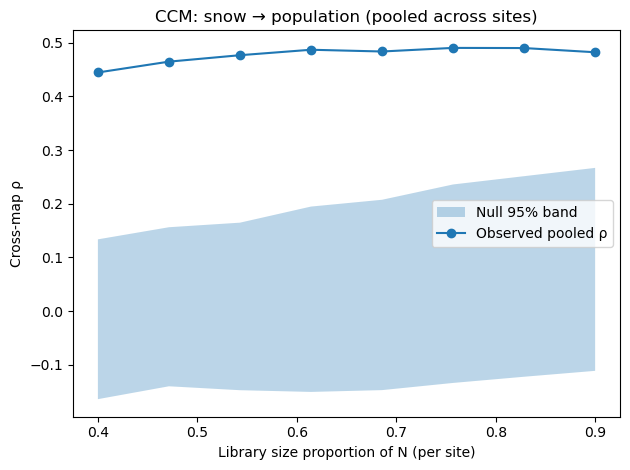

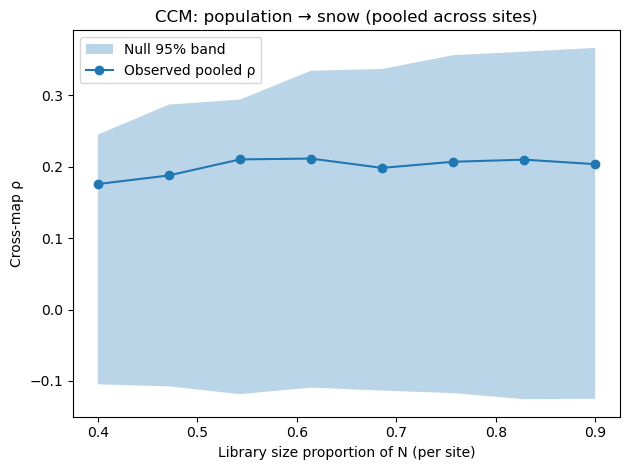

In [5]:
# run_multispatial_ccm_visual.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------
# 0) Generate synthetic data
# ------------------------
rng = np.random.default_rng(42)

loc_ids = [f"loc{i+1}" for i in range(4)]
lengths = rng.integers(15, 31, size=4).tolist()  # 15..30
records = []

for loc, n in zip(loc_ids, lengths):
    # snow persistence in [0,1], AR(1) + noise -> rank map to 0..1
    phi = 0.7
    e = rng.normal(0, 0.3, size=n)
    s = np.zeros(n)
    s[0] = rng.normal(0, 1)
    for t in range(1, n):
        s[t] = phi * s[t-1] + e[t]
    ranks = pd.Series(s).rank(method="average").to_numpy()
    snow = (ranks - 1) / (n - 1)

    # population density with causal input from lagged snow + AR(1)
    pop = np.zeros(n)
    pop[0] = rng.normal(0, 1)
    for t in range(1, n):
        pop[t] = 0.55 * pop[t-1] + 0.45 * snow[t-1] + rng.normal(0, 0.2)
    pop = (pop - pop.min()) / (pop.max() - pop.min() + 1e-9) * 10  # scale to 0..10

    years = np.arange(2000, 2000 + n)
    for t in range(n):
        records.append({
            "location": loc,
            "year": int(years[t]),
            "snow_persist_Apr24_May15": float(snow[t]),
            "wolverine_density": float(pop[t]),
        })

df = pd.DataFrame(records)
df.to_csv("wolverine_synth_multispatial.csv", index=False)
print("Saved synthetic data -> wolverine_synth_multispatial.csv")
print({loc: n for loc, n in zip(loc_ids, lengths)})

# ------------------------
# 1) Multispatial-style CCM using pyEDM
# ------------------------
import pyEDM

# EDM params
E = 3           # try 2–5
TAU = -1        # let pyEDM choose default delay
TP = 0          # CCM synchrony; we align/lag ourselves
SAMPLES = 200   # bootstrap within CCM per lib size
RNG_SEED = 123
LAG_YEARS = 1   # snow(t) -> population(t+1)

# Use a fixed proportion grid (consistent across sites)
P_GRID = np.linspace(0.4, 0.9, 8)  # 0.40, 0.47, ..., 0.90

def align_with_lag(site_df, lag=LAG_YEARS):
    """Align driver (snow) and response (pop) so CCM uses Tp=0."""
    g = site_df.sort_values("year").reset_index(drop=True).copy()
    if lag > 0:
        # snow leads: drop last lag from snow and first lag from pop
        g = g.iloc[lag:].reset_index(drop=True).copy()
        g["snow_persist_Apr24_May15"] = site_df["snow_persist_Apr24_May15"].iloc[:-lag].to_numpy()
    elif lag < 0:
        lag = abs(lag)
        g = g.iloc[:-lag].reset_index(drop=True).copy()
        g["snow_persist_Apr24_May15"] = site_df["snow_persist_Apr24_May15"].iloc[lag:].to_numpy()
    return g

def libsizes_from_proportions(N, E, p_grid):
    # create integer library sizes per proportion, clipped to [E+2, N-3]
    L = np.clip(np.rint(p_grid * N).astype(int), E + 2, max(E + 2, N - 3))
    # ensure strictly increasing & unique
    L = np.unique(L)
    # guard against very short series
    if L.size == 0:
        L = np.array([max(E + 2, min(N - 3, N // 2))])
    return L

def ccm_site_with_pgrid(site_df, p_grid=P_GRID, E=E, tau=TAU, Tp=TP, samples=SAMPLES, seed=RNG_SEED):
    """Run CCM in both directions for a single site using a fixed proportion grid.
       Returns dict with: L_per_site (actual int lib sizes used), rho_s2p, rho_p2s,
       each array aligned to p_grid via NaNs where duplicate/invalid sizes occurred.
    """
    data = site_df[["snow_persist_Apr24_May15", "wolverine_density"]].copy()
    N = len(data)
    Ls = libsizes_from_proportions(N, E, p_grid)
    libSizes_str = " ".join(map(str, Ls))

    out = pyEDM.CCM(
        dataFrame=data,
        columns="snow_persist_Apr24_May15",
        target="wolverine_density",
        libSizes=libSizes_str,
        E=E, tau=tau, Tp=Tp,
        sample=samples,
        embedded=False, noTime=True,
        includeData=False, ignoreNan=True,
        seed=seed
    )

    # Map results back to p_grid positions:
    # For each p in p_grid we computed an intended Li = round(p*N) (then clipped).
    intended_L = np.rint(p_grid * N).astype(int)
    intended_L = np.clip(intended_L, E + 2, max(E + 2, N - 3))
    # If clipping or rounding caused duplicates, some positions won’t match unique Ls.
    # We'll fill with NaN for those.
    L_used = out.iloc[:, 0].to_numpy()
    rho_s2p_map = dict(zip(L_used, out.iloc[:, 1].to_numpy()))
    rho_p2s_map = dict(zip(L_used, out.iloc[:, 2].to_numpy()))

    rho_s2p = np.array([rho_s2p_map.get(L, np.nan) for L in intended_L])
    rho_p2s = np.array([rho_p2s_map.get(L, np.nan) for L in intended_L])

    return {"L_per_site": intended_L, "rho_s2p": rho_s2p, "rho_p2s": rho_p2s}

# Run CCM per site (with 1-year biological lag)
site_curves = {}
for loc, g in df.groupby("location"):
    g = align_with_lag(g, lag=LAG_YEARS)
    site_curves[loc] = ccm_site_with_pgrid(g)

# Pooled (mean across sites, ignoring NaNs)
def pooled_curve(site_curves, key="rho_s2p"):
    M = np.vstack([curv[key] for curv in site_curves.values()])
    return np.nanmean(M, axis=0)

obs_pooled_s2p = pooled_curve(site_curves, "rho_s2p")
obs_pooled_p2s = pooled_curve(site_curves, "rho_p2s")

# ------------------------
# 2) Null distributions (circular shifts), both directions
# ------------------------
def circular_shift(arr, k):
    k = int(k) % len(arr)
    return np.concatenate([arr[-k:], arr[:-k]]) if k else arr

def null_run(df, p_grid=P_GRID, seed=RNG_SEED):
    rng = np.random.default_rng(seed)
    null_site_curves = {}
    for loc, g in df.groupby("location"):
        # random non-zero shift per site
        k = rng.integers(1, max(2, len(g)))
        g = g.sort_values("year").reset_index(drop=True).copy()
        g["snow_persist_Apr24_May15"] = circular_shift(
            g["snow_persist_Apr24_May15"].to_numpy(), k
        )
        g = align_with_lag(g, lag=LAG_YEARS)
        null_site_curves[loc] = ccm_site_with_pgrid(g, p_grid=p_grid)
    return (pooled_curve(null_site_curves, "rho_s2p"),
            pooled_curve(null_site_curves, "rho_p2s"))

N_PERM = 10  # increase for more stable bands
null_s2p_all = []
null_p2s_all = []
for i in range(N_PERM):
    s2p_i, p2s_i = null_run(df, p_grid=P_GRID, seed=RNG_SEED + i + 1)
    null_s2p_all.append(s2p_i)
    null_p2s_all.append(p2s_i)

null_s2p_all = np.vstack(null_s2p_all)  # shape (N_PERM, len(P_GRID))
null_p2s_all = np.vstack(null_p2s_all)

# Compute null bands (2.5–97.5%) and quick p-values at each grid point
low_s2p = np.nanquantile(null_s2p_all, 0.025, axis=0)
hi_s2p  = np.nanquantile(null_s2p_all, 0.975, axis=0)
low_p2s = np.nanquantile(null_p2s_all, 0.025, axis=0)
hi_p2s  = np.nanquantile(null_p2s_all, 0.975, axis=0)

# One-sided p-values: P(null >= observed) for s2p; and for reverse too
pval_s2p = np.array([(null_s2p_all[:, j] >= obs_pooled_s2p[j]).mean()
                     for j in range(len(P_GRID))])
pval_p2s = np.array([(null_p2s_all[:, j] >= obs_pooled_p2s[j]).mean()
                     for j in range(len(P_GRID))])

# Save a quick table
out_tab = pd.DataFrame({
    "lib_prop": P_GRID,
    "rho_obs_snow_to_pop": obs_pooled_s2p,
    "null_low_s2p": low_s2p,
    "null_hi_s2p": hi_s2p,
    "pval_s2p": pval_s2p,
    "rho_obs_pop_to_snow": obs_pooled_p2s,
    "null_low_p2s": low_p2s,
    "null_hi_p2s": hi_p2s,
    "pval_p2s": pval_p2s
})
out_tab.to_csv("ccm_multispatial_summary.csv", index=False)
print("\nSaved summary -> ccm_multispatial_summary.csv")
print(out_tab.round(3).to_string(index=False))

# ------------------------
# 3) Plots (two figures, one per direction)
# ------------------------
def plot_with_null_band(x, y_obs, y_low, y_hi, title, ylab):
    plt.figure()
    # null band
    plt.fill_between(x, y_low, y_hi, alpha=0.3, label="Null 95% band")
    # observed line
    plt.plot(x, y_obs, marker="o", label="Observed pooled ρ")
    plt.xlabel("Library size proportion of N (per site)")
    plt.ylabel(ylab)
    plt.title(title)
    plt.legend()
    plt.tight_layout()

plot_with_null_band(
    P_GRID, obs_pooled_s2p, low_s2p, hi_s2p,
    title="CCM: snow → population (pooled across sites)",
    ylab="Cross-map ρ"
)
plot_with_null_band(
    P_GRID, obs_pooled_p2s, low_p2s, hi_p2s,
    title="CCM: population → snow (pooled across sites)",
    ylab="Cross-map ρ"
)

plt.show()


In [4]:
# save as run_multispatial_ccm.py
import numpy as np
import pandas as pd

# ------------------------
# 0) Generate synthetic data
# ------------------------
rng = np.random.default_rng(42)

loc_ids = [f"loc{i+1}" for i in range(4)]
lengths = rng.integers(15, 31, size=4).tolist()  # 15..30
records = []

for loc, n in zip(loc_ids, lengths):
    # snow persistence in [0,1], AR(1) + noise -> rank map to 0..1
    phi = 0.7
    e = rng.normal(0, 0.3, size=n)
    s = np.zeros(n)
    s[0] = rng.normal(0, 1)
    for t in range(1, n):
        s[t] = phi * s[t-1] + e[t]
    ranks = pd.Series(s).rank(method="average").to_numpy()
    snow = (ranks - 1) / (n - 1)

    # population density with causal input from lagged snow + AR(1)
    pop = np.zeros(n)
    pop[0] = rng.normal(0, 1)
    for t in range(1, n):
        pop[t] = 0.55 * pop[t-1] + 0.45 * snow[t-1] + rng.normal(0, 0.2)
    pop = (pop - pop.min()) / (pop.max() - pop.min() + 1e-9) * 10  # scale to 0..10

    years = np.arange(2000, 2000 + n)
    for t in range(n):
        records.append({
            "location": loc,
            "year": int(years[t]),
            "snow_persist_Apr24_May15": float(snow[t]),
            "wolverine_density": float(pop[t]),
        })

df = pd.DataFrame(records)
df.to_csv("wolverine_synth_multispatial.csv", index=False)
print("Saved synthetic data -> wolverine_synth_multispatial.csv")
print({loc: n for loc, n in zip(loc_ids, lengths)})

# ------------------------
# 1) Multispatial-style CCM using pyEDM
# ------------------------
import pyEDM

E = 3          # embedding dimension (try 2–5)
TAU = -1        # delay for embedding
TP = 0         # CCM uses Tp=0 (synchrony) when you’ve aligned/lagged series yourself
SAMPLES = 200  # bootstrap within CCM for each lib size
RNG_SEED = 123
LAG_YEARS = 1  # biological hypothesis: snow(t) -> population(t+1)

def align_with_lag(site_df, lag=LAG_YEARS):
    """Align driver (snow) and response (pop) so CCM uses Tp=0."""
    g = site_df.sort_values("year").reset_index(drop=True).copy()
    if lag > 0:
        # snow leads: drop last lag from snow and first lag from pop
        g = g.iloc[lag:].reset_index(drop=True).copy()
        g["snow_persist_Apr24_May15"] = site_df["snow_persist_Apr24_May15"].iloc[:-lag].to_numpy()
    elif lag < 0:
        # population leads (usually not your biological case)
        lag = abs(lag)
        g = g.iloc[:-lag].reset_index(drop=True).copy()
        g["snow_persist_Apr24_May15"] = site_df["snow_persist_Apr24_May15"].iloc[lag:].to_numpy()
    return g

def ccm_site(site_df, E=E, tau=TAU, Tp=TP, samples=SAMPLES, seed=RNG_SEED):
    """Run CCM in both directions for a single site; return DataFrame of rho vs LibSize."""
    data = site_df[["snow_persist_Apr24_May15", "wolverine_density"]].copy()

    N = len(data)
    max_lib = max(E + 2, min(N - 3, N))
    Ls = np.unique(np.clip((np.linspace(0.4, 0.9, 10) * N).astype(int), E + 2, max_lib))
    libSizes = " ".join(map(str, Ls))

    out = pyEDM.CCM(
        dataFrame=data,
        columns="snow_persist_Apr24_May15",
        target="wolverine_density",
        libSizes=libSizes,
        E=E, tau=tau, Tp=Tp,
        sample=samples,          # controls random library resampling in Python
        embedded=False, noTime=True,
        includeData=False, ignoreNan=True,
        seed=seed
    )

    return pd.DataFrame({
        "LibSize": out.iloc[:, 0].to_numpy(),
        "rho_snow_to_pop": out.iloc[:, 1].to_numpy(),
        "rho_pop_to_snow": out.iloc[:, 2].to_numpy(),
    })


# Run CCM per site with lag alignment
site_results = {}
for loc, g in df.groupby("location"):
    g = align_with_lag(g, lag=LAG_YEARS)
    site_results[loc] = ccm_site(g)

# ------------------------
# 2) Pooled summary across locations (bootstrap over sites)
# ------------------------
def pooled_maxlib_summary(site_results, n_boot=2000, seed=RNG_SEED):
    rng = np.random.default_rng(seed)
    per_site = []
    for loc, res in site_results.items():
        idx = res["LibSize"].idxmax()
        per_site.append({
            "location": loc,
            "LibSize": int(res.loc[idx, "LibSize"]),
            "rho_snow_to_pop": float(res.loc[idx, "rho_snow_to_pop"]),
            "rho_pop_to_snow": float(res.loc[idx, "rho_pop_to_snow"]),
        })
    per_site = pd.DataFrame(per_site)

    locs = per_site["location"].tolist()
    boot_s2p, boot_p2s = [], []
    for _ in range(n_boot):
        sample_locs = rng.choice(locs, size=len(locs), replace=True)
        sub = per_site.set_index("location").loc[sample_locs]
        boot_s2p.append(sub["rho_snow_to_pop"].mean())
        boot_p2s.append(sub["rho_pop_to_snow"].mean())
    boot_s2p = np.array(boot_s2p)
    boot_p2s = np.array(boot_p2s)

    q = lambda a: np.quantile(a, [0.025, 0.975])
    return per_site, {
        "pooled_mean_rho_snow_to_pop": float(boot_s2p.mean()),
        "pooled_95CI_snow_to_pop_low": float(q(boot_s2p)[0]),
        "pooled_95CI_snow_to_pop_high": float(q(boot_s2p)[1]),
        "pooled_mean_rho_pop_to_snow": float(boot_p2s.mean()),
        "pooled_95CI_pop_to_snow_low": float(q(boot_p2s)[0]),
        "pooled_95CI_pop_to_snow_high": float(q(boot_p2s)[1]),
        "n_sites": len(site_results),
    }

per_site, pooled = pooled_maxlib_summary(site_results)
print("\nPer-site CCM (largest library size):")
print(per_site.to_string(index=False))

print("\nPooled multispatial-style summary (bootstrap across sites):")
for k, v in pooled.items():
    print(f"{k}: {v:.3f}" if isinstance(v, float) else f"{k}: {v}")

# ------------------------
# 3) Quick circular shift null (optional)
# ------------------------
def circular_shift(arr, k):
    k = int(k) % len(arr)
    return np.concatenate([arr[-k:], arr[:-k]]) if k else arr

def ccm_site_shifted(site_df, shift_years, **kwargs):
    g = site_df.sort_values("year").reset_index(drop=True).copy()
    g = align_with_lag(g, lag=LAG_YEARS)
    g["snow_persist_Apr24_May15"] = circular_shift(
        g["snow_persist_Apr24_May15"].to_numpy(), shift_years
    )
    return ccm_site(g, **kwargs)

def pooled_null(df, n_perm=300, seed=RNG_SEED):
    rng = np.random.default_rng(seed)
    boot = []
    for _ in range(n_perm):
        shifted = {}
        for loc, g in df.groupby("location"):
            k = rng.integers(1, max(2, len(g)))  # non-zero shift per site
            shifted[loc] = ccm_site_shifted(g, shift_years=k)
        _, pooled_null = pooled_maxlib_summary(shifted, n_boot=500, seed=seed)
        boot.append(pooled_null["pooled_mean_rho_snow_to_pop"])
    return np.array(boot)

# Uncomment to run the null (takes extra seconds):
null_dist = pooled_null(df, n_perm=300)
obs = pooled["pooled_mean_rho_snow_to_pop"]
pval = (null_dist >= obs).mean()
print(f"\nNull mean rho_snow_to_pop ~ {null_dist.mean():.3f}; "
      f"95% CI {np.quantile(null_dist,[0.025,0.975])}")
print(f"Approx one-sided p-value for snow→pop: {pval:.3f}")


Saved synthetic data -> wolverine_synth_multispatial.csv
{'loc1': 16, 'loc2': 27, 'loc3': 25, 'loc4': 22}



Per-site CCM (largest library size):
location  LibSize  rho_snow_to_pop  rho_pop_to_snow
    loc1       12         0.791607         0.488356
    loc2       23         0.772046         0.538120
    loc3       21        -0.187978        -0.161415
    loc4       18         0.549822        -0.062375

Pooled multispatial-style summary (bootstrap across sites):
pooled_mean_rho_snow_to_pop: 0.484
pooled_95CI_snow_to_pop_low: 0.052
pooled_95CI_snow_to_pop_high: 0.782
pooled_mean_rho_pop_to_snow: 0.205
pooled_95CI_pop_to_snow_low: -0.112
pooled_95CI_pop_to_snow_high: 0.513
n_sites: 4


Process SpawnPoolWorker-1476:
Process SpawnPoolWorker-1475:


KeyboardInterrupt: 

In [ ]:
!pip install pyEDM pandas numpy matplotlib
